First of all, make sure your environment has installed the latest version of [🤗 Optimum Graphcore](https://github.com/huggingface/optimum-graphcore).

In [1]:
pip install git+https://github.com/huggingface/optimum-graphcore.git;

Looking in indexes: https://pypi.org/simple, https://pypi.python.org/simple/
  Cloning https://github.com/huggingface/optimum-graphcore.git to /tmp/pip-req-build-vdejgdgn
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/optimum-graphcore.git /tmp/pip-req-build-vdejgdgn
  Resolved https://github.com/huggingface/optimum-graphcore.git to commit 9ecdc44a1342acc75ac368044609556df22e5b0e
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


Note: you may need to restart the kernel to use updated packages.


Also make sure all the packages required for text classification are installed.

In [2]:
! pip install scikit-learn;
! pip install matplotlib;
! pip install tokenizers==0.11.1

Looking in indexes: https://pypi.org/simple, https://pypi.python.org/simple/
Looking in indexes: https://pypi.org/simple, https://pypi.python.org/simple/
Looking in indexes: https://pypi.org/simple, https://pypi.python.org/simple/


Let's print out the versions of Transformers and Optimum Graphcore:

In [3]:
import transformers
import optimum.graphcore

print(transformers.__version__)
print(optimum.graphcore.__version__)

4.20.1
0.4.4.dev0


# Fine-tuning BERT on a text classification task using packing

This notebook is an alternative for [Fine-tuning BERT on a text classification task](text_classification.ipynb) showing how to implement packing for BERT step by step and use if for fine-tuning on `GLUE/sst2` text classification. This includes packing the dataset and adapting an existing BERT model. Packing consists in concatenating several input sequences into one to increase the computational efficiency. More details about packing can be found in the [blog post](https://www.graphcore.ai/posts/introducing-packed-bert-for-2x-faster-training-in-natural-language-processing) and the original [paper](https://arxiv.org/abs/2107.02027).

In this notebook, we will see how to fine-tune one of the [🤗 Transformers](https://github.com/huggingface/transformers) model to a text classification task of the [GLUE Benchmark](https://gluebenchmark.com/).

![Widget inference on a text classification task](images/text_classification.png)

The GLUE Benchmark is a group of nine classification tasks on sentences or pairs of sentences which are:

- [CoLA](https://nyu-mll.github.io/CoLA/) (Corpus of Linguistic Acceptability) Determine if a sentence is grammatically correct or not.is a  dataset containing sentences labeled grammatically correct or not.
- [MNLI](https://arxiv.org/abs/1704.05426) (Multi-Genre Natural Language Inference) Determine if a sentence entails, contradicts or is unrelated to a given hypothesis. (This dataset has two versions, one with the validation and test set coming from the same distribution, another called mismatched where the validation and test use out-of-domain data.)
- [MRPC](https://www.microsoft.com/en-us/download/details.aspx?id=52398) (Microsoft Research Paraphrase Corpus) Determine if two sentences are paraphrases from one another or not.
- [QNLI](https://rajpurkar.github.io/SQuAD-explorer/) (Question-answering Natural Language Inference) Determine if the answer to a question is in the second sentence or not. (This dataset is built from the SQuAD dataset.)
- [QQP](https://data.quora.com/First-Quora-Dataset-Release-Question-Pairs) (Quora Question Pairs2) Determine if two questions are semantically equivalent or not.
- [RTE](https://aclweb.org/aclwiki/Recognizing_Textual_Entailment) (Recognizing Textual Entailment) Determine if a sentence entails a given hypothesis or not.
- [SST-2](https://nlp.stanford.edu/sentiment/index.html) (Stanford Sentiment Treebank) Determine if the sentence has a positive or negative sentiment.
- [STS-B](http://ixa2.si.ehu.es/stswiki/index.php/STSbenchmark) (Semantic Textual Similarity Benchmark) Determine the similarity of two sentences with a score from 1 to 5.
- [WNLI](https://cs.nyu.edu/faculty/davise/papers/WinogradSchemas/WS.html) (Winograd Natural Language Inference) Determine if a sentence with an anonymous pronoun and a sentence with this pronoun replaced are entailed or not. (This dataset is built from the Winograd Schema Challenge dataset.)

We will see how to easily load the dataset for each one of those tasks and use packed BERT to fine-tune a model on it. Each task is named by its acronym, with `mnli-mm` standing for the mismatched version of MNLI (so same training set as `mnli` but different validation and test sets):

In [4]:
GLUE_TASKS = ["cola", "mnli", "mnli-mm", "mrpc", "qnli", "qqp", "rte", "sst2", "stsb", "wnli"]

**For this Packed bert demo, we will cover (single-label) sequence classification on `sst2` dataset. But `task` can be changed to run the other `GLUE` tasks . However, training hyperparameters may need some tuning for these other tasks.**

In this notebook, we are using both data parallelism and pipeline parallelism (see this [tutorial](https://github.com/graphcore/tutorials/tree/master/tutorials/pytorch/tut2_efficient_data_loading) for more). Therefore the global batch size, which is the actual number of samples used for the weight update, is determined with three factors:
- global batch size = micro_batch_size * gradient accumulation steps * replication factor

and replication factor is determined by `pod_type`, which will be used as a key to select the replication factor from a dictionary defined in the IPU config file. For example, the dictionary in the IPU config file [Graphcore/roberta-base-ipu](https://huggingface.co/Graphcore/roberta-base-ipu/blob/main/ipu_config.json) looks like this:
- "replication_factor": {"pod4": 1, "pod8": 2, "pod16": 4, "pod32": 8, "pod64": 16, "default": 1}

Depending on you model and the pod machine you are using, you might need to adjust these three batch-size-related arguments.

By default this notebook is configured to run on 4 IPUs.

Finally, `max_seq_length` is the length we are going to pad the sentences to, so it should not be larger than the maximum length of the model. Set those seven parameters, then the rest of the notebook should run smoothly:

Given the small size of the sequences in `sst2`, we can reduce the model input size to `max_seq_length = 256`.

In [5]:
task = "sst2"
model_checkpoint = "bert-base-uncased"
ipu_config_name = "Graphcore/bert-base-uncased"
micro_batch_size = 2
gradient_accumulation_steps = 32
pod_type = "pod4"
max_seq_length = 256

## Loading the dataset

We will use the [🤗 Datasets](https://github.com/huggingface/datasets) library to download the data and get the metric we need to use for evaluation (to compare our model to the benchmark). This can be easily done with the functions `load_dataset` and `load_metric`.  

In [6]:
from datasets import load_dataset, load_metric, Dataset

Apart from `mnli-mm` being a special code, we can directly pass our task name to those functions. `load_dataset` will cache the dataset to avoid downloading it again the next time you run this cell.

In [7]:
actual_task = "mnli" if task == "mnli-mm" else task
dataset = load_dataset("glue", actual_task)
metric = load_metric('glue', actual_task)

Found cached dataset glue (/home/alexandrec/.cache/huggingface/datasets/glue/sst2/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)


  0%|          | 0/3 [00:00<?, ?it/s]

/tmp/ipykernel_2818717/1389288479.py:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric('glue', actual_task)


The `dataset` object itself is [`DatasetDict`](https://huggingface.co/docs/datasets/package_reference/main_classes.html#datasetdict), which contains one key for the training, validation and test set (with more keys for the mismatched validation and test set in the special case of `mnli`).

In [8]:
dataset

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 67349
    })
    validation: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 872
    })
    test: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 1821
    })
})

To access an actual element, you need to select a split first, then give an index:

In [9]:
dataset["train"][0]

{'sentence': 'hide new secretions from the parental units ',
 'label': 0,
 'idx': 0}

To get a sense of what the data looks like, the following function will show some examples picked randomly in the dataset.

In [10]:
import datasets
import random
import pandas as pd
from IPython.display import display, HTML

def show_random_elements(dataset, num_examples=10):
    assert num_examples <= len(dataset), "Can't pick more elements than there are in the dataset."
    picks = []
    for _ in range(num_examples):
        pick = random.randint(0, len(dataset)-1)
        while pick in picks:
            pick = random.randint(0, len(dataset)-1)
        picks.append(pick)
    
    df = pd.DataFrame(dataset[picks])
    for column, typ in dataset.features.items():
        if isinstance(typ, datasets.ClassLabel):
            df[column] = df[column].transform(lambda i: typ.names[i])
    display(HTML(df.to_html()))

In [11]:
show_random_elements(dataset["train"])

,sentence,label,idx
0,to suffer ',negative,22714
1,stylized swedish fillm about a modern city where all the religious and civic virtues that hold society in place are in tatters .,positive,59290
2,"'s still tainted by cliches , painful improbability and murky points",negative,22205
3,", sorrow , laugther , and tears",positive,15427
4,in the way the ivan character accepts the news of his illness so quickly but still finds himself unable to react,negative,26571
5,"offers big , fat , dumb",negative,39794
6,"funny in a sick , twisted sort of way .",positive,54178
7,gorgeous,positive,38780
8,that propels her into the upper echelons of the directing world,positive,37590
9,"'s just tediously bad , something to be fully forgotten",negative,46262


The metric is an instance of [`datasets.Metric`](https://huggingface.co/docs/datasets/package_reference/main_classes.html#datasets.Metric):

In [12]:
metric

Metric(name: "glue", features: {'predictions': Value(dtype='int64', id=None), 'references': Value(dtype='int64', id=None)}, usage: """
Compute GLUE evaluation metric associated to each GLUE dataset.
Args:
    predictions: list of predictions to score.
        Each translation should be tokenized into a list of tokens.
    references: list of lists of references for each translation.
        Each reference should be tokenized into a list of tokens.
Returns: depending on the GLUE subset, one or several of:
    "accuracy": Accuracy
    "f1": F1 score
    "pearson": Pearson Correlation
    "spearmanr": Spearman Correlation
    "matthews_correlation": Matthew Correlation
Examples:

    >>> glue_metric = datasets.load_metric('glue', 'sst2')  # 'sst2' or any of ["mnli", "mnli_mismatched", "mnli_matched", "qnli", "rte", "wnli", "hans"]
    >>> references = [0, 1]
    >>> predictions = [0, 1]
    >>> results = glue_metric.compute(predictions=predictions, references=references)
    >>> print(res

You can call its `compute` method with your predictions and labels directly and it will return a dictionary with the metric(s) value:

In [13]:
import numpy as np

fake_preds = np.random.randint(0, 2, size=(64,))
fake_labels = np.random.randint(0, 2, size=(64,))
metric.compute(predictions=fake_preds, references=fake_labels)

{'accuracy': 0.4375}

Note that `load_metric` has loaded the proper metric associated to your task, which is:

- for CoLA: [Matthews Correlation Coefficient](https://en.wikipedia.org/wiki/Matthews_correlation_coefficient)
- for MNLI (matched or mismatched): Accuracy
- for MRPC: Accuracy and [F1 score](https://en.wikipedia.org/wiki/F1_score)
- for QNLI: Accuracy
- for QQP: Accuracy and [F1 score](https://en.wikipedia.org/wiki/F1_score)
- for RTE: Accuracy
- for SST-2: Accuracy
- for STS-B: [Pearson Correlation Coefficient](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient) and [Spearman's_Rank_Correlation_Coefficient](https://en.wikipedia.org/wiki/Spearman%27s_rank_correlation_coefficient)
- for WNLI: Accuracy

so the metric object only computes the one(s) needed for your task.

## Preprocessing the data

Before we can feed those texts to our model, we need to preprocess them. This is done by a 🤗 Transformers `Tokenizer` which will (as the name indicates) tokenize the inputs (including converting the tokens to their corresponding IDs in the pretrained vocabulary) and put it in a format the model expects, as well as generate the other inputs that model requires.

To do all of this, we instantiate our tokenizer with the `AutoTokenizer.from_pretrained` method, which will ensure:

- we get a tokenizer that corresponds to the model architecture we want to use,
- we download the vocabulary used when pretraining this specific checkpoint.

That vocabulary will be cached, so it's not downloaded again the next time we run the cell.

In [14]:
from transformers import AutoTokenizer
    
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, use_fast=True)

We pass along `use_fast=True` to the call above to use one of the fast tokenizers (backed by Rust) from the 🤗 Tokenizers library. Those fast tokenizers are available for almost all models, but if you got an error with the previous call, remove that argument.

You can directly call this tokenizer on one sentence or a pair of sentences:

In [15]:
tokenizer("Hello, this one sentence!", "And this sentence goes with it.")

{'input_ids': [101, 7592, 1010, 2023, 2028, 6251, 999, 102, 1998, 2023, 6251, 3632, 2007, 2009, 1012, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

Depending on the model you selected, you will see different keys in the dictionary returned by the cell above. They don't matter much for what we're doing here (just know they are required by the model we will instantiate later), you can learn more about them in [this tutorial](https://huggingface.co/transformers/preprocessing.html) if you're interested.

To preprocess our dataset, we will thus need the names of the columns containing the sentence(s). The following dictionary keeps track of the correspondence task to column names:

In [16]:
task_to_keys = {
    "cola": ("sentence", None),
    "mnli": ("premise", "hypothesis"),
    "mnli-mm": ("premise", "hypothesis"),
    "mrpc": ("sentence1", "sentence2"),
    "qnli": ("question", "sentence"),
    "qqp": ("question1", "question2"),
    "rte": ("sentence1", "sentence2"),
    "sst2": ("sentence", None),
    "stsb": ("sentence1", "sentence2"),
    "wnli": ("sentence1", "sentence2"),
}

We can double check it does work on our current dataset:

In [17]:
sentence1_key, sentence2_key = task_to_keys[task]
if sentence2_key is None:
    print(f"Sentence: {dataset['train'][0][sentence1_key]}")
else:
    print(f"Sentence 1: {dataset['train'][0][sentence1_key]}")
    print(f"Sentence 2: {dataset['train'][0][sentence2_key]}")

Sentence: hide new secretions from the parental units 


We can then write the function that will preprocess our samples. We just feed them to the `tokenizer` with the three arguments.`truncation=True` will ensure that an input longer than maximum length will be truncated to the maximum length. `max_length=max_seq_length` sets the maximum length of a sequence.

**Note: since we will use packing later, we don't want to perform any padding in the tokenizer.**

In [18]:
# no padding for packing
def preprocess_function(examples):
    if sentence2_key is None:
        return tokenizer(examples[sentence1_key], truncation=True, max_length=max_seq_length)
    return tokenizer(examples[sentence1_key], examples[sentence2_key], truncation=True, max_length=max_seq_length)

This function works with one or several examples. In the case of several examples, the tokenizer will return a list of lists for each key:

In [19]:
preprocess_function(dataset['train'][:5])

{'input_ids': [[101, 5342, 2047, 3595, 8496, 2013, 1996, 18643, 3197, 102], [101, 3397, 2053, 15966, 1010, 2069, 4450, 2098, 18201, 2015, 102], [101, 2008, 7459, 2049, 3494, 1998, 10639, 2015, 2242, 2738, 3376, 2055, 2529, 3267, 102], [101, 3464, 12580, 8510, 2000, 3961, 1996, 2168, 2802, 102], [101, 2006, 1996, 5409, 7195, 1011, 1997, 1011, 1996, 1011, 11265, 17811, 18856, 17322, 2015, 1996, 16587, 2071, 2852, 24225, 2039, 102]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}

To apply this function on all the sentences (or pairs of sentences) in our dataset, we just use the `map` method of our `dataset` object we created earlier. This will apply the function on all the elements of all the splits in `dataset`, so our training, validation and testing data will be preprocessed in one single command.

In [20]:
encoded_dataset = dataset.map(preprocess_function, batched=True)
len(encoded_dataset['train'])

Loading cached processed dataset at /home/alexandrec/.cache/huggingface/datasets/glue/sst2/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad/cache-82412aa6396b9933.arrow
Loading cached processed dataset at /home/alexandrec/.cache/huggingface/datasets/glue/sst2/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad/cache-d29a91fb10977f93.arrow
Loading cached processed dataset at /home/alexandrec/.cache/huggingface/datasets/glue/sst2/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad/cache-af01fefce31fb4d7.arrow


67349

Even better, the results are automatically cached by the 🤗 Datasets library to avoid spending time on this step the next time you run your notebook. The 🤗 Datasets library is normally smart enough to detect when the function you pass to map has changed (and thus requires to not use the cache data). For instance, it will properly detect if you change the task in the first cell and rerun the notebook. 🤗 Datasets warns you when it uses cached files, you can pass `load_from_cache_file=False` in the call to `map` to not use the cached files and force the preprocessing to be applied again.

Note that we passed `batched=True` to encode the texts by batches together. This is to leverage the full benefit of the fast tokenizer we loaded earlier, which will use multi-threading to treat the texts in a batch concurrently.

###  Packing the dataset

To implement packing, we need to pack our dataset first. Each new element will be a "pack" containing at most `max_seq_per_pack` sequences.

In [21]:
max_seq_per_pack = 6

### Packing algorithm

In order to pack efficiently, we will use an histogram-based algorithm (SPFHP) presented in the [blog post](https://www.graphcore.ai/posts/introducing-packed-bert-for-2x-faster-training-in-natural-language-processing) https://github.com/graphcore/tutorials/tree/master/blogs_code/packedBERT. First we need to generate the histogram of the sequences lengths in our dataset:

In [22]:
def generate_histogram(unpadded_input_ids, max_seq_len):
    dataset_seq_lens:list = np.array([len(seq) for seq in unpadded_input_ids])
    histogram = np.zeros(max_seq_len, dtype=np.int64)
    seq_lens, counts = np.unique(dataset_seq_lens, return_counts=True)
    histogram[seq_lens - 1] = counts

    return histogram

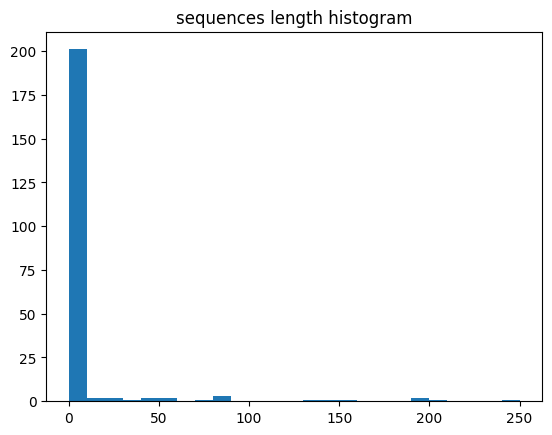

In [23]:
validation_key = "validation_mismatched" if task == "mnli-mm" else "validation_matched" if task == "mnli" else "validation"

train_dataset = encoded_dataset['train']
val_dataset = encoded_dataset[validation_key]

train_hist = generate_histogram(train_dataset['input_ids'], max_seq_length )
val_hist = generate_histogram(val_dataset['input_ids'], max_seq_length )

import matplotlib.pyplot as plt
plt.hist(train_hist, bins = [k for k in range(0,max_seq_length,10)]) 
plt.title("sequences length histogram") 
plt.show()

Now we apply the `Shortest pack first histogram packing` algorithm to generate a packing strategy from the histogram.

In [24]:
import time
from scipy import optimize, stats
import numpy as np
from collections import defaultdict

def add_pack(pack, count, tmp, final, limit, offset, max_sequence_length=512):
    """Filter out packs that reached maximum length or number of components."""
    if len(pack) == limit or offset == 0:
        final[offset].append((count, pack))
    else:
        tmp[offset].append((count, pack))


#^SPFHP - Shortest pack first histogram packing
def SPFHP(histogram, max_sequence_length, max_sequences_per_pack):
    """Shortest-pack-first histogram-packing."""
    start = time.time()
    reversed_histogram = np.flip(histogram)
    # Initialize main strategy data dictionary.
    # The key indicates how many tokens are left for full length.
    # The value is a list of tuples, consisting of counts and respective packs.
    # A pack is a (sorted) list of sequence length values that get concatenated.
    tmp_strategies_per_length = defaultdict(list)
    strategies_per_length = defaultdict(list)
    # Index i indicates here, how much space is left, due to reversed histogram
    for i in range(max_sequence_length):
        n_sequences_to_bin = reversed_histogram[i]
        length_to_bin = max_sequence_length - i
        offset = i + 1  # largest possible offset
        while n_sequences_to_bin > 0:
            if (length_to_bin + offset) in tmp_strategies_per_length:
                # extract shortest pack that will get modified
                n_sequences_to_pack, pack = tmp_strategies_per_length[
                    length_to_bin + offset].pop()
                new_pack = pack + [length_to_bin]
                count = min(n_sequences_to_pack, n_sequences_to_bin)
                if n_sequences_to_pack > n_sequences_to_bin:
                    # old pack gets reduced
                    n_sequences_to_pack -= n_sequences_to_bin
                    tmp_strategies_per_length[length_to_bin + offset].append(
                        (n_sequences_to_pack, pack))
                    n_sequences_to_bin = 0
                else:
                    n_sequences_to_bin -= n_sequences_to_pack
                add_pack(new_pack, count,
                         tmp_strategies_per_length, strategies_per_length,
                         max_sequences_per_pack, offset)
                # clean up to speed up main key search
                if not tmp_strategies_per_length[length_to_bin + offset]:
                    tmp_strategies_per_length.pop(length_to_bin + offset)
            else:
                offset -= 1
            # Does not fit anywhere. Create new pack.
            if offset < 0:
                add_pack([length_to_bin], n_sequences_to_bin,
                         tmp_strategies_per_length, strategies_per_length,
                         max_sequences_per_pack, i)
                n_sequences_to_bin = 0
    # merge all strategies
    for key in tmp_strategies_per_length:
        strategies_per_length[key].extend(tmp_strategies_per_length[key])
    # flatten strategies dictionary
    strategy_set = []
    strategy_repeat_count = []
    for key in strategies_per_length:
        for count, pack in strategies_per_length[key]:
            pack.reverse()
            strategy_set.append(pack)
            strategy_repeat_count.append(count)

    # Summarize efficiency of solution
    duration = time.time() - start
    sequence_lengths = np.arange(1, max_sequence_length + 1)
    strategy_repeat_count = np.array(strategy_repeat_count)
    n_strategies = len(strategy_set)
    old_number_of_samples = histogram.sum()
    new_number_of_samples = strategy_repeat_count.sum()
    sequences = sum([count*len(pack) for count, pack in
                     zip(strategy_repeat_count, strategy_set)])
    total_tokens = max_sequence_length * new_number_of_samples
    empty_tokens = sum([count*(max_sequence_length-sum(pack)) for count, pack
                        in zip(strategy_repeat_count, strategy_set)])
    efficiency = 100 - empty_tokens / total_tokens * 100
    speedup_upper_bound = 1.0 / (1 - (histogram*(1 - sequence_lengths / max_sequence_length)).sum() / old_number_of_samples)
    packing_factor = sequences/sum(strategy_repeat_count)
    
    print(f"Packing efficiency (fraction of real tokens): {efficiency:3.4f}\n",
          f"Speed-up theoretical limit: {speedup_upper_bound:3.4f}\n",
          f"Achieved speed-up over un-packed dataset: {old_number_of_samples/new_number_of_samples:3.5f}\n",
          f"Runtime: Packed {old_number_of_samples} sequences in {duration:3.3f} seconds\n",
          f"Average packing factor: {packing_factor}")
    

    return strategy_set, np.array(strategy_repeat_count)

`strategy_set` is a list of lists containing the sequences lenghts we can pack together.

`strategy_repeat_count` gives the corresponding number of time we can create each pack of `strategy_set`.

In [25]:
train_strategy = SPFHP(train_hist, max_seq_length, max_seq_per_pack)
val_strategy = SPFHP(val_hist, max_seq_length, max_seq_per_pack)

Packing efficiency (fraction of real tokens): 26.8058
 Speed-up theoretical limit: 19.2203
 Achieved speed-up over un-packed dataset: 5.15216
 Runtime: Packed 67349 sequences in 0.002 seconds
 Average packing factor: 5.152157282741738
Packing efficiency (fraction of real tokens): 56.7648
 Speed-up theoretical limit: 10.1733
 Achieved speed-up over un-packed dataset: 5.77483
 Runtime: Packed 872 sequences in 0.002 seconds
 Average packing factor: 5.774834437086093


Now we need to create the actual packed dataset object. 
We pick the sequences and pack them based on their length and following the strategy we just generated. Once they are packed, we also need to pad the sequences to the `max_seq_lentgh` to maintain a constant input size.

Notes:
- A specific `attention_mask` is generated: It contains a unique index for each sequence of the pack and `0` for the remaining padding tokens.
    - Example of 3 sequences: `attention_mask = [1,1,1,1,1,1,2,2,2,2,2,3,3,3,3,3,0,...,0,1,2,3]`


- The [CLS] tokens of each sequence are moved at the end of the pack.
    - For instance: `[CLS,a,b,c] + [CLS, d,e,f] + [CLS, g,h,i] -> [a,b,c,d,e,f,g,h,i,...,CLS,CLS,CLS]`
    

- The `position_ids` of a pack contains the concatenated `position_ids` of each sequences 
    - For instance given 3 sequences: `[0,1,2,3,4] + [0,1,2,3] + [0,1,2] -> [1,2,3,4,1,2,3,1,2,...,0,0,0]` (note: the CLS tokens position id '0' are also moved the end of the pack)
    
- `labels` and `token_type_ids` are also packed to correspond the `input_ids` pack.

In [26]:
import itertools
def create_dataset_from_strategy(data, strategy_set, strategy_repeat_count, max_seq_len, max_seq_per_pack):
    total_num_packs:int = np.sum(strategy_repeat_count)
        

    # Sort the sequences by length
    dataset_seq_lens = np.array([len(seq) for seq in data['input_ids']])
    len_sorted_seq_idxs = np.argsort(dataset_seq_lens)
    len_sorted_seq_lens = dataset_seq_lens[len_sorted_seq_idxs]
    sorted_seqs = np.stack((len_sorted_seq_lens, len_sorted_seq_idxs))


    # Get the data from the tokenised dataset
    input_ids = data['input_ids']
    attention_mask = data['attention_mask']
    token_type_ids = data['token_type_ids']
    labels = data['label']
    
    # Prepare the manually padded constant sized data
    packed_input_ids = np.zeros((total_num_packs, max_seq_len), dtype=int)
    packed_attention_mask = np.zeros((total_num_packs, max_seq_len), dtype=int)
    packed_token_type_ids = np.zeros((total_num_packs, max_seq_len), dtype=int)
    packed_position_ids = np.zeros((total_num_packs, max_seq_len), dtype=int)
    packed_labels = -100 * np.ones((total_num_packs, max_seq_per_pack), dtype=int)
    
    # Pack the data using the developed strategies
    pack_index = 0
    for i in range(len(strategy_repeat_count)):
        strategy = strategy_set[i]
        # This is the offset we apply to the start positions to account for the positional change of the logits when unmasking the pack to extract a set of logits for each sequence in the pack
        for _ in range(strategy_repeat_count[i]):

            '''Key terms in loop:

            * sorted_seqs: (shape [2, dataset])
                - index 0: sorted lengths of each sequence in dataset
                    -- e.g. sorted_seqs[0,12] gives the length of the sequence at dataset position at index: sorted_seqs[1,12]
                - index 1: index of corresponding lengths in the dataset
                    -- e.g. dataset[sorted_seqs[1,12]] returns dataset sequence at index: sorted_seqs[1,12]

            * ref_inds: (shape [strategy_set])
                - the indices of the [length, dataset index] pair in sorted_seqs (this is used to remove/clear sorted_seqs as data is packed).
                    -- e.g sorted_seqs[0, ref_inds] = -1 will nullify the sequence length at positions in [array] ref_inds such that they cannot be called to pull data from those indices again.

            * inds: (shape [strategy_set])
                - the indices in the actual dataset, called using the indices of sorted_seqs retrieved from ref_inds.
                    --e.g. > inds = sorted_seqs[1, ref_inds]
                           > packed data = concatenate(dataset[inds])
            '''

            ref_inds = []
            for x in strategy:
                ref_ind = np.argwhere(sorted_seqs[0] == x)[-1]
                sorted_seqs[0, ref_ind] = -1
                ref_inds.append(ref_ind)

            inds = sorted_seqs[1, ref_inds].ravel()

            # Exclude the CLS tokens to put them at the end later
            input_id_pack = list(itertools.chain(*[input_ids[x][1:] for x in inds]))
            attention_mask_pack = list(itertools.chain(*[itertools.repeat(n+1, len(attention_mask[v])-1) for n,v in enumerate(inds)]))
            token_type_ids_pack = list(itertools.chain(*[token_type_ids[x][1:] for x in inds]))
            position_ids_pack = list(itertools.chain(*[range(1, len(attention_mask[v])) for n,v in enumerate(inds)]))

            # Create the equivalent tokenised packed dataset
            packed_input_ids[pack_index, :len(input_id_pack)] = input_id_pack
            packed_attention_mask[pack_index, :len(attention_mask_pack)] = attention_mask_pack
            packed_token_type_ids[pack_index, :len(token_type_ids_pack)] = token_type_ids_pack
            packed_position_ids[pack_index, :len(position_ids_pack)] = position_ids_pack
            labels_pack = [labels[x] for x in inds]
            packed_labels[pack_index, :len(labels_pack)] = labels_pack

            # Now add the CLS tokens and their masks at the end of the pack
            packed_input_ids[pack_index, -max_seq_per_pack:] = [input_ids[0][0] for _ in range(max_seq_per_pack)]
            packed_attention_mask[pack_index, -max_seq_per_pack:] = list(range(1, max_seq_per_pack+1))

            pack_index += 1
            
    new_dataset = Dataset.from_dict({ "input_ids": packed_input_ids,
                                      "attention_mask": packed_attention_mask,
                                      "token_type_ids": packed_token_type_ids,
                                      "position_ids": packed_position_ids,
                                      "labels": packed_labels
                                })
    new_dataset.set_format(type='torch', columns=new_dataset.features)
    return new_dataset

In [27]:
packed_train_dataset = create_dataset_from_strategy(train_dataset, train_strategy[0], train_strategy[1], max_seq_length, max_seq_per_pack)
packed_val_dataset = create_dataset_from_strategy(val_dataset, val_strategy[0], val_strategy[1], max_seq_length, max_seq_per_pack)

print(packed_train_dataset)

Dataset({
    features: ['input_ids', 'attention_mask', 'token_type_ids', 'position_ids', 'labels'],
    num_rows: 13072
})


Let's visualize one sample of the new `packed_train_dataset`:

In [28]:
packed_train_dataset[3020]

{'input_ids': tensor([13401,  1005,  1055, 22391,  2104, 10841, 14343,  3372,  1997, 18439,
          1998,  5988, 16778,  2278, 22012,   102,  1996,  3494,  1010,  2040,
          2024,  2061, 19337,  2666, 12423,  2008,  2017,  2514,  2054,  2027,
          2514,   102,  1996,  3609,  3168,  1997,  6990,  2210,  1016,  2003,
          2049,  2087,  6234,  1998,  2087,  5793,  5165,   102,  3310,  2013,
          1996,  9191,  1010,  4895,  2378,  4048, 16313,  2098,  4616,  2011,
          2049,  2599,  5889,   102,  1005,  2310,  2464,  1999,  1037,  2096,
          1010,  1037,  2812,  4063,  2083,  6247,  1011,  2041,  3430,   102,
         11896,  2000,  3073,  2172,  2062, 12369,  2084,  1996,  2503,  5930,
          1997,  1037,  7950,  2338,  6598,  1012,   102,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,   

## Fine-tuning the model

Now that our data is ready, we can download the pretrained model and fine-tune it. The number of labels will be required.

In [29]:
from transformers import AutoModelForSequenceClassification, default_data_collator
from optimum.graphcore import IPUConfig, IPUTrainer, IPUTrainingArguments

num_labels = 3 if task.startswith("mnli") else 1 if task=="stsb" else 2

### Implement Packed BERT

A few model modifications are required to make packing work with BERT.
We will extend the existing class `BertForSequenceClassification`.

First let's load a default BERT configuration using `AutoConfig`.

In [30]:
from transformers import AutoConfig
config = AutoConfig.from_pretrained(model_checkpoint)
config.max_position_embeddings = max_seq_length
print(config)

BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 256,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.20.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}



Packing sequences increases the number of elements per batch.
In order to reuse the classifications heads from `transformers` library, we need a special pooler. Instead of pooling the hidden states of a single sequence, it's pooling multiple ones (given the maxium number of sequences in the pack) and ordering them along the batch dimension. So the output size of the pooler is: `[batch-size x max_sequences_per_pack, hidden_size]`

From the Loss point-of-view , everything will appear as if the batch-size was larger (`batch-size x max_sequences_per_pack`).
When the number of sequences in the pack is lower than `max_sequences_per_pack`, padding is ignored by using the default `ignore_index` (-100) of the loss as a special labels (this was already done in the dataset preprocessing, cf: *Packing the dataset*).

![pooling](images/pooling.png)

In [31]:
import torch
import torch.nn as nn

class PackedBertPooler(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.max_sequences_per_pack = config.max_sequences_per_pack
        self.dense = nn.Linear(config.hidden_size, config.hidden_size)
        self.activation = nn.Tanh()

    def forward(self, hidden_states):
        # We "pool" the model by simply taking the hidden states corresponding
        # to the last max_sequences_per_pack tokens. Note that the [CLS] tokens
        # are always located at the end of the pack. When the actual number of
        # sequences is lower than max_sequences_per_pack, we still slice out
        # the last max_sequences_per_pack tokens, but we will not use all of
        # them during loss calculation.
        sh = hidden_states.shape
        last_tokens_tensors = hidden_states[:, -self.max_sequences_per_pack:]
        last_reshape = last_tokens_tensors.reshape(sh[0]*self.max_sequences_per_pack, sh[2])
        # output size: [bs x max_sequences_per_pack, hidden_size]
        output = self.dense(last_reshape)
        output = self.activation(output)
        return output

##### Attention mask
The attention mask should be used in a specific way in packed-BERT.
We will create a 2D attention mask like in the following example.
By doing so, the cross-attention will treat separately each sequence of the pack (and it will also ignore the padding).
![attn-mask](images/attention-mask.png)

To get a better intuition here is an example showing how to transform the 1D attention mask:

In [32]:
# 1 : Flat attention mask genreated by the dataset. Each sequence has a different index. 0 is padding.
attention_mask = torch.tensor([[1,1,2,2,3,3,3,4,4,4,4,0,0,0,0,1,2,3,4]])
# 2: Generate the boolean 2D attention mask
attention_mask = attention_mask[:, None, :].repeat(1, attention_mask.shape[1], 1)
attention_mask = (attention_mask == attention_mask.transpose(1, 2)) * (attention_mask != 0)
# Notice that the mask is always False for the padding tokens.
print(attention_mask.to(int))

tensor([[[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
         [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
         [0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
         [0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
         [0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
         [0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
         [0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
         [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1],
         [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1],
         [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1],
         [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Now let's integrate this idea to the input of packed BERT.

By inheriting from `BertPipelineMixin` , the `paralellize()` method is already implemented for the BERT body. We overloaded it to also place the classifier on the last IPU.

In [40]:
import poptorch
from optimum.graphcore.models.bert.modeling_bert import BertPipelineMixin
from transformers import BertForSequenceClassification


class PackedBertForSequenceClassification(BertForSequenceClassification, BertPipelineMixin):
    
    def __init__(self, config):
        super().__init__(config)
        self.config.max_sequences_per_pack = max_seq_per_pack
        self.bert.pooler = PackedBertPooler(config)
        
    def parallelize(self):
            super().parallelize()
            last_ipu = self.ipu_config.ipus_per_replica - 1
            self.classifier = poptorch.BeginBlock(self.classifier, "Classifier Output", ipu_id=last_ipu)
            return self
    
    def forward(self, input_ids=None, attention_mask=None, token_type_ids=None, position_ids=None, labels=None):
        
        seq_len = input_ids.shape[1]
        attention_mask = attention_mask[:, None, :].repeat(1, seq_len, 1)
        attention_mask = (attention_mask == attention_mask.transpose(1, 2)) * (attention_mask != 0)
        
        output = super().forward(input_ids = input_ids,
                                 attention_mask=attention_mask,
                                 token_type_ids=token_type_ids,
                                 position_ids=position_ids,
                                 labels=labels)

        # For validation: output should keep the same batch dimension as the original input
        if not self.training:
            output.logits = output.logits.reshape([-1,max_seq_per_pack, num_labels])

        return output

In [41]:
model = PackedBertForSequenceClassification(config).from_pretrained("bert-base-uncased", num_labels=num_labels).train()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing PackedBertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing PackedBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing PackedBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of PackedBertForSequenceClassification were not initialized from

The warning is telling us we are throwing away some weights and randomly initializing some other. This is absolutely normal in this case, because we are removing the head used to pretrain the model on a masked language modeling objective and replacing it with a new head for which we don't have pretrained weights, so the library warns us we should fine-tune this model before using it for inference, which is exactly what we are going to do.

We can first test the model on CPU and observe that the output logits have now the size [batch_size x max_seq_per_pack, 2] = [12, 2] with this notebook default values.

In [42]:
from transformers.data.data_collator import default_data_collator


loader = torch.utils.data.DataLoader(packed_train_dataset,
                             batch_size=micro_batch_size,
                             shuffle=True,
                             drop_last=True,
                             collate_fn=default_data_collator)
data = iter(loader).next()
outputs = model(**data)
print("logits: ", outputs)

logits:  SequenceClassifierOutput(loss=tensor(0.7834, grad_fn=<NllLossBackward0>), logits=tensor([[ 0.1241, -0.5591],
        [ 0.0029, -0.5513],
        [ 0.0344, -0.4092],
        [-0.2084, -0.8723],
        [-0.1712, -0.3608],
        [ 0.0211, -0.5014],
        [-0.1167, -0.7668],
        [-0.1232, -0.6668],
        [-0.1602, -0.9111],
        [-0.0286, -0.5740],
        [ 0.1363, -0.1791],
        [-0.2363, -0.8429]], grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)


Now let's prepare the model for IPU

First, we set the model in half precision:

In [36]:
model.half()

PackedBertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, e

We need to define the `IPUConfig`, which is a class that specifies attributes and configuration parameters to compile and put the model on the device. We initialize it with one config name or path, which we set earlier. Then we use it to set the mode attribute `model.ipu_config` 

In [37]:
ipu_config = IPUConfig.from_pretrained(
    ipu_config_name,
    executable_cache_dir = "/tmp/exe_cache/",
    replication_factor=1,
    gradient_accumulation_steps=gradient_accumulation_steps,
    device_iterations = 32,
    inference_replication_factor=1
)

/localdata/alexandrec/SDK/poplar_sdk-ubuntu_20_04-3.0.0+1145-1b114aac3a/3.0.0+1145_poptorch/lib/python3.8/site-packages/optimum/graphcore/ipu_configuration.py:148: UserWarning: The "enable_half_first_order_momentum" parameter is deprecated
  warnings.warn('The "enable_half_first_order_momentum" parameter is deprecated')


For validation, we need to define a function to compute the metrics from the predictions, which will just use the `metric` we loaded earlier, the only preprocessing we have to do is to take the argmax of our predicted logits (our just squeeze the last axis in the case of STS-B). To ignore the `-100` labels from uncomplete packs, we use a boolean mask.

In [38]:
metric_name = "pearson" if task == "stsb" else "matthews_correlation" if task == "cola" else "accuracy"
model_name = model_checkpoint.split("/")[-1]

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    
#     Remove the padding labels
    mask = (labels != -100)
    labels = labels[mask]
    predictions = predictions[mask]
    if task != "stsb":
        predictions = np.argmax(predictions, axis=1)
    else:
        predictions = predictions[:, 0]
    return metric.compute(predictions=predictions, references=labels)

In [43]:
args = IPUTrainingArguments(
    "/tmp/"+f"{model_name}-finetuned-{task}",
    learning_rate=0.00009,
    lr_scheduler_type = "cosine",
    warmup_ratio=0.1,
    per_device_train_batch_size=micro_batch_size,
    per_device_eval_batch_size=4,
    num_train_epochs=2,
    weight_decay=0,
    metric_for_best_model=metric_name,
    dataloader_drop_last=True,
    dataloader_mode="async_rebatched",
    logging_steps=1,
    pod_type=pod_type,
    gradient_accumulation_steps=gradient_accumulation_steps,
    push_to_hub=False,
    
)


trainer = IPUTrainer(
    model,
    ipu_config,
    args,
    train_dataset=packed_train_dataset,
    eval_dataset=packed_val_dataset,
    compute_metrics=compute_metrics
)

The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Setting replicated_tensor_sharding to False when replication_factor=1
Overriding IPU config: gradient_accumulation_steps=32
-------------------- Device Allocation --------------------
Embedding --> IPU 0
Encoder 0  --> IPU 1
Encoder 1  --> IPU 1
Encoder 2  --> IPU 1
Encoder 3  --> IPU 1
Encoder 4  --> IPU 2
Encoder 5  --> IPU 2
Encoder 6  --> IPU 2
Encoder 7  --> IPU 2
Encoder 8  --> IPU 3
Encoder 9  --> IPU 3
Encoder 10 --> IPU 3
Encoder 11 --> IPU 3


In [44]:
trainer.train()

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Compiling Model...
[15:03:53.208] [poptorch:cpp] [warning] [TRACING-2] Allocated tensor: 13 sizes=[1, 512], type=Int (type coerced from Long to Int)
[15:03:53.208] [poptorch:cpp] [warning] [TRACING-2] Allocated tensor: 15 sizes=[1, 512], type=Int (type coerced from Long to Int)
[15:03:53.328] [poptorch:cpp] [warning] Parameter bert.embeddings.position_ids: impl_ 0x88b36b0 type xla ID 14 sizes [1, 512] dtype int was downgraded to constant because PopART doesn't support non floating point parameters
[15:03:53.328] [poptorch:cpp] [warning] Parameter bert.embeddings.token_type_ids: impl_ 0x8862cb0 type xla ID 16 sizes [1, 512] dtype int was downgraded to constant because PopART doesn't support non floating point parameters
[15:03:53.334] [poptorch:cpp] [warning] [TRACING-2] Allocated tensor: 409 sizes=[2, 256], type=Int (type coerced from Long to Int)
[15:03:53.334] [poptorch:cpp] [warning] [TRACING-2] Allocated tensor: 411 sizes=[2, 256], type=Int (type coerced from Long to Int)
[15:03:53

  0%|          | 0/12 [00:00<?, ?it/s]

{'loss': 0.7256, 'learning_rate': 4.5e-05, 'epoch': 0.17}
{'loss': 0.5747, 'learning_rate': 9e-05, 'epoch': 0.33}
{'loss': 0.0968, 'learning_rate': 8.779754323328193e-05, 'epoch': 0.5}
{'loss': 0.1924, 'learning_rate': 8.140576474687264e-05, 'epoch': 0.67}
{'loss': 0.2295, 'learning_rate': 7.14503363531613e-05, 'epoch': 0.83}
{'loss': 0.0856, 'learning_rate': 5.890576474687264e-05, 'epoch': 1.0}
{'loss': 0.0141, 'learning_rate': 4.5e-05, 'epoch': 1.17}
{'loss': 0.0443, 'learning_rate': 3.1094235253127374e-05, 'epoch': 1.33}
{'loss': 0.0082, 'learning_rate': 1.8549663646838714e-05, 'epoch': 1.5}
{'loss': 0.0213, 'learning_rate': 8.59423525312737e-06, 'epoch': 1.67}
{'loss': 0.4536, 'learning_rate': 2.2024567667180914e-06, 'epoch': 1.83}




Training completed. Do not forget to share your model on huggingface.co/models =)




{'loss': 0.0236, 'learning_rate': 0.0, 'epoch': 2.0}
{'train_runtime': 36.3568, 'train_samples_per_second': 675.967, 'train_steps_per_second': 0.33, 'train_loss': 0.20580355326334634, 'epoch': 2.0}


TrainOutput(global_step=12, training_loss=0.20580355326334634, metrics={'train_runtime': 36.3568, 'train_samples_per_second': 675.967, 'train_steps_per_second': 0.33, 'train_loss': 0.20580355326334634, 'epoch': 2.0})

***About the performances:*** `IPUTrainer` doesn't take into account that we have packed data samples when computing the speed metrics. So the actual throughput estimation can be obtained by multiplying the `samples_per_second` by the average packing factor of the dataset. (These were obtained in the `packing_algorithm` section: `5.15` for `sst2` training set and `5.77` for validation set).

In [45]:
trainer.evaluate()

Compiling Model...
[15:05:02.621] [poptorch:cpp] [warning] [TRACING-2] Allocated tensor: 13 sizes=[1, 512], type=Int (type coerced from Long to Int)
[15:05:02.621] [poptorch:cpp] [warning] [TRACING-2] Allocated tensor: 15 sizes=[1, 512], type=Int (type coerced from Long to Int)
[15:05:02.716] [poptorch:cpp] [warning] Parameter bert.embeddings.position_ids: impl_ 0xc800c50 type xla ID 14 sizes [1, 512] dtype int was downgraded to constant because PopART doesn't support non floating point parameters
[15:05:02.716] [poptorch:cpp] [warning] Parameter bert.embeddings.token_type_ids: impl_ 0x3e8897c0 type xla ID 16 sizes [1, 512] dtype int was downgraded to constant because PopART doesn't support non floating point parameters
[15:05:02.718] [poptorch:cpp] [warning] [TRACING-2] Allocated tensor: 409 sizes=[4, 256], type=Int (type coerced from Long to Int)
[15:05:02.718] [poptorch:cpp] [warning] [TRACING-2] Allocated tensor: 411 sizes=[4, 256], type=Int (type coerced from Long to Int)
[15:05:0

  0%|          | 0/9 [00:00<?, ?it/s]

{'eval_loss': 0.220947265625,
 'eval_accuracy': 0.9199522102747909,
 'eval_runtime': 0.7446,
 'eval_samples_per_second': 193.403,
 'eval_steps_per_second': 12.088,
 'epoch': 2.0}

To see how your model fared you can compare it to the [GLUE Benchmark leaderboard](https://gluebenchmark.com/leaderboard).

You can now upload the result of the training to the Hub, just execute this instruction:

In [ ]:
trainer.push_to_hub()

You can now share this model with all your friends, family, favorite pets: they can all load it with the identifier `"your-username/the-name-you-picked"` so for instance:

```python
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained("sgugger/my-awesome-model")
```

## Faster inference:

When training, the packing factor does affect the convergence the same way as bigger batch size would do. However, for inference, we are free to use a bigger packing factor to speed it up.
Let's try it on `sst2` with `max_seq_per_pack = 12`.

In [46]:
max_seq_per_pack = 12

To have enough examples, we will reuse the training set.

In [47]:
dataset = load_dataset("glue", "sst2")
encoded_dataset = dataset.map(preprocess_function, batched=True)
inference_dataset = encoded_dataset['train'] # train set again, to have enough examples
infer_strategy = SPFHP(train_hist, max_seq_length, max_seq_per_pack)
packed_dataset = create_dataset_from_strategy(train_dataset, infer_strategy[0], infer_strategy[1], max_seq_length, max_seq_per_pack)

Found cached dataset glue (/home/alexandrec/.cache/huggingface/datasets/glue/sst2/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)


  0%|          | 0/3 [00:00<?, ?it/s]

Loading cached processed dataset at /home/alexandrec/.cache/huggingface/datasets/glue/sst2/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad/cache-82412aa6396b9933.arrow
Loading cached processed dataset at /home/alexandrec/.cache/huggingface/datasets/glue/sst2/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad/cache-d29a91fb10977f93.arrow
Loading cached processed dataset at /home/alexandrec/.cache/huggingface/datasets/glue/sst2/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad/cache-af01fefce31fb4d7.arrow


Packing efficiency (fraction of real tokens): 34.9567
 Speed-up theoretical limit: 19.2203
 Achieved speed-up over un-packed dataset: 6.71877
 Runtime: Packed 67349 sequences in 0.002 seconds
 Average packing factor: 6.718774940143655


We can see that the average packing factor `6.7` is not close to the maximum now (12), this is still an imporvement compared to the previous `5.7`.

Let's also modify the configuration of the model for inference. For speed up, we can us a single IPU and 4 replicas by changing `layers_per_ipu` , `inference_replication_factor` and `ipus_per_replica` and also use a larger `batch-size`.

In [48]:
ipu_config.layers_per_ipu = [12]
ipu_config.inference_device_iterations = 32
ipu_config.inference_replication_factor = 4
ipu_config.ipus_per_replica = 1

In [49]:
model = PackedBertForSequenceClassification(config).from_pretrained("bert-base-uncased", num_labels=num_labels)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing PackedBertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing PackedBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing PackedBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of PackedBertForSequenceClassification were not initialized from

In [53]:
args = IPUTrainingArguments(
    "/tmp/"+f"{model_name}-finetuned-{task}-fast-inference",
    per_device_eval_batch_size=8,
    dataloader_mode="async_rebatched",
    dataloader_drop_last=True,
    logging_steps=10,
    pod_type=pod_type
)

trainer = IPUTrainer(
    model,
    ipu_config,
    args,
    eval_dataset=packed_dataset,
    compute_metrics=compute_metrics
)

The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Setting replicated_tensor_sharding to False when replication_factor=1
-------------------- Device Allocation --------------------
Embedding --> IPU 0
Encoder 0  --> IPU 0
Encoder 1  --> IPU 0
Encoder 2  --> IPU 0
Encoder 3  --> IPU 0
Encoder 4  --> IPU 0
Encoder 5  --> IPU 0
Encoder 6  --> IPU 0
Encoder 7  --> IPU 0
Encoder 8  --> IPU 0
Encoder 9  --> IPU 0
Encoder 10 --> IPU 0
Encoder 11 --> IPU 0


In [54]:
trainer.evaluate()

Compiling Model...
[15:08:30.589] [poptorch:cpp] [warning] [TRACING-2] Allocated tensor: 13 sizes=[1, 512], type=Int (type coerced from Long to Int)
[15:08:30.590] [poptorch:cpp] [warning] [TRACING-2] Allocated tensor: 15 sizes=[1, 512], type=Int (type coerced from Long to Int)
[15:08:30.754] [poptorch:cpp] [warning] Parameter bert.embeddings.position_ids: impl_ 0x1f4320f30 type xla ID 14 sizes [1, 512] dtype int was downgraded to constant because PopART doesn't support non floating point parameters
[15:08:30.754] [poptorch:cpp] [warning] Parameter bert.embeddings.token_type_ids: impl_ 0x1ca9c1640 type xla ID 16 sizes [1, 512] dtype int was downgraded to constant because PopART doesn't support non floating point parameters
[15:08:30.755] [poptorch:cpp] [warning] [TRACING-2] Allocated tensor: 409 sizes=[8, 256], type=Int (type coerced from Long to Int)
[15:08:30.756] [poptorch:cpp] [warning] [TRACING-2] Allocated tensor: 411 sizes=[8, 256], type=Int (type coerced from Long to Int)
[15:0

  0%|          | 0/9 [00:00<?, ?it/s]

{'eval_loss': 0.828125,
 'eval_accuracy': 0.4437953539318151,
 'eval_runtime': 5.0264,
 'eval_samples_per_second': 1833.521,
 'eval_steps_per_second': 1.791}

As before, to get a correct throughput estimation we need to multiply `eval_samples_per_second` by the average packing factor (6.72).